# Modelo de Aprendizaje Automático:

Después de completar el Análisis Exploratorio de Datos (EDA) para comprender la naturaleza de nuestros datos, avanzamos hacia la creación de un modelo de recomendación basado en la similitud del coseno.
El enfoque del modelo se fundamenta en la similitud entre juegos. Al proporcionar el nombre o identificador de un juego específico, el sistema generará una lista de 5 juegos recomendados que comparten similitudes con el juego de referencia. Esta metodología es ideal para usuarios que buscan descubrir títulos relacionados o similares a sus juegos preferidos.

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Cargamos nuestro datos 

In [2]:
df_output = pd.read_csv("data2/output_steam_games_limpio9.csv")
df_items = pd.read_csv("data2/user_items_limpio5.csv")
df_reviews = pd.read_csv("data2/user_reviews_limpio7.csv")

In [3]:
df_reviews.columns

Index(['user_id', 'item_id', 'recommend', 'year_posted', 'sentiment_analysis'], dtype='object')

In [4]:
df_items.columns

Index(['user_id', 'items_count', 'item_id', 'item_name', 'playtime_forever'], dtype='object')

## 1. Definición del Puntaje de Recomendación
En esta etapa, definimos el puntaje de recomendación ('Recommendation') que guiará nuestras recomendaciones. Este puntaje, en una escala del 1 al 5, combina el análisis de sentimiento de las reseñas y las recomendaciones de los usuarios.

In [5]:
def recommendation_score(sentiment_analysis, recommend):
    if sentiment_analysis == 0:  #Review negativa
        return 1
    elif sentiment_analysis == 1 and recommend == True:  #Review neutral y juego recomendado
        return 3
    elif sentiment_analysis == 1 and recommend == False:  #Review neutral y juego no recomendado
        return 2
    elif sentiment_analysis == 2 and recommend == True:  #Review positivo y juego recomendado
        return 5
    elif sentiment_analysis == 2 and recommend == False:  #Review positivo y juego no recomendado
        return 4

## 2. Creación de la Columna "Recommendation"
Generamos una columna adicional llamada "recommendation" y aplicamos la función de cálculo de puntaje a los datos.

In [6]:
df_reviews["recommendation"] = df_reviews.apply(
    lambda row: recommendation_score(row["sentiment_analysis"], row["recommend"]),
    axis=1)

In [7]:
df_reviews.head()

,user_id,item_id,recommend,year_posted,sentiment_analysis,recommendation
0,76561197970982479,1250,True,2011,2,5
1,76561197970982479,22200,True,2011,2,5
2,76561197970982479,43110,True,2011,1,3
3,js41637,251610,True,2014,2,5
4,js41637,227300,True,2013,1,3


## 3. Selección de Variables Clave
Filtramos las columnas clave para nuestro modelo de recomendación, incluyendo 'user_id', 'item_id', y 'recommend' del DataFrame df_reviews.

In [8]:
columns_reviews = ["user_id","item_id","recommendation"]
filtered_df_reviews = df_reviews[columns_reviews]
filtered_df_reviews.head()

,user_id,item_id,recommendation
0,76561197970982479,1250,5
1,76561197970982479,22200,5
2,76561197970982479,43110,3
3,js41637,251610,5
4,js41637,227300,3


## 4. Extracción de Juegos Únicos
Extraemos los valores únicos de los nombres de los juegos ('app_name') y de los item_id de los juegos del DataFrame df_items.

In [9]:
unique_games = df_items[["item_name","item_id"]]
unique_games= unique_games.drop_duplicates()
unique_games

,item_name,item_id
0,Team Fortress Classic,20
1,Day of Defeat,30
2,Deathmatch Classic,40
3,Ricochet,60
4,Psychonauts,3830
...,...,...
2672124,Cloudy with a Chance of Meatballs,33270
2768204,Mimpi Dreams,444770
2964351,Alienware Steam Machine,353390
2972260,ChaosTower,354280


## 5. Fusión de DataFrames
Unimos el DataFrame que contiene los juegos únicos y el DataFrame filtrado de reseñas de usuarios.

In [10]:
merged_data = pd.merge(filtered_df_reviews, unique_games, on="item_id")
merged_data

,user_id,item_id,recommendation,item_name
0,76561197970982479,1250,5,Killing Floor
1,death-hunter,1250,5,Killing Floor
2,DJKamBer,1250,3,Killing Floor
3,diego9031,1250,3,Killing Floor
4,76561198081962345,1250,3,Killing Floor
...,...,...,...,...
31315,K1NGCJS,294230,3,Millie
31316,laislabonita75,305920,1,Another Perspective
31317,Gamer0009,306040,5,The Howler
31318,llDracuwulf,307130,3,Asteria


recommendation
1     905
2     626
3    1359
4     305
5    1399
Name: item_id, dtype: int64
recommendation
1     4346
2     1836
3    11818
4      644
5    12676
Name: user_id, dtype: int64
recommendation
1     905
2     626
3    1359
4     305
5    1399
Name: item_name, dtype: int64


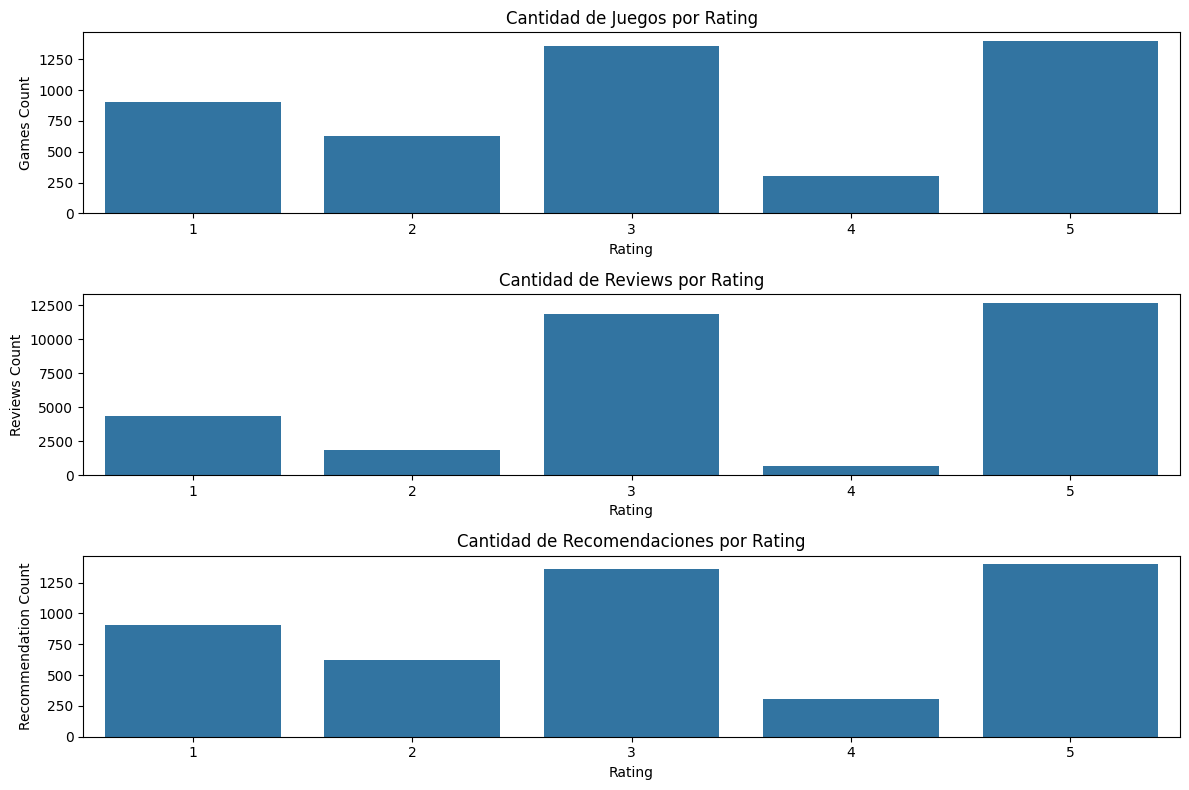

In [11]:
rating_counts = merged_data.groupby("recommendation")["item_id"].nunique()
review_counts = merged_data.groupby("recommendation")["user_id"].count()
game_counts = merged_data.groupby("recommendation")["item_name"].nunique()
print(rating_counts)
print(review_counts)
print(game_counts)

summary_df = pd.DataFrame({
    "Rating": rating_counts.index,
    "Games Count": game_counts.values,
    "Reviews Count": review_counts.values,
    "Recommendation Count": rating_counts.values
})

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
sns.barplot(x="Rating", y="Games Count", data=summary_df)
plt.title("Cantidad de Juegos por Rating")

plt.subplot(3, 1, 2)
sns.barplot(x="Rating", y="Reviews Count", data=summary_df)
plt.title("Cantidad de Reviews por Rating")

plt.subplot(3, 1, 3)
sns.barplot(x="Rating", y="Recommendation Count", data=summary_df)
plt.title("Cantidad de Recomendaciones por Rating")

plt.tight_layout()
plt.show()

## 6. Crear DataFrame con Recommendation Normalizados

In [12]:
# Copiamos el dataframe de nuestro interes pero sin la columna item_id ya que no es relevante
df_final = merged_data[["user_id","item_name","recommendation"]]
df_final

,user_id,item_name,recommendation
0,76561197970982479,Killing Floor,5
1,death-hunter,Killing Floor,5
2,DJKamBer,Killing Floor,3
3,diego9031,Killing Floor,3
4,76561198081962345,Killing Floor,3
...,...,...,...
31315,K1NGCJS,Millie,3
31316,laislabonita75,Another Perspective,1
31317,Gamer0009,The Howler,5
31318,llDracuwulf,Asteria,3


In [13]:
table_ = df_final.pivot_table(index=["user_id"], columns=["item_name"], values="recommendation")
table_

item_name,0RBITALIS,1001 Spikes,12 Labours of Hercules,12 is Better Than 6,123 Slaughter Me Street,140,16 Bit Arena,16bit Trader,1943 Megami Strike,20XX,...,iBomber Defense,iBomber Defense Pacific,iPi Recorder 2,iRacing,inMomentum,klocki,oO,the static speaks my name,theBlu,theHunter
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ace--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ionex--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Azsael-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Beave-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zv_odd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zvanik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zynxgameth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Normalizamos nuestra matriz para poder ser analizada posteriormente en el modelo
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(scaler.fit_transform(table_.fillna(0)), index=table_.index, columns=table_.columns)
normalized_df = normalized_df.T
normalized_df = normalized_df.loc[:,(normalized_df != 0).any(axis=0)]
normalized_df

user_id,--000--,--ace--,--ionex--,-Azsael-,-Beave-,-GM-Dragon,-Kenny,-Mad-,-PRoSlayeR-,-SEVEN-,...,zucchin1,zuilde,zukuta,zumpo,zuzuga2003,zv_odd,zvanik,zynxgameth,zyr0n1c,zzoptimuszz
item_name,,,,,,,,,,,,,,,,,,,,,
0RBITALIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001 Spikes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Labours of Hercules,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 is Better Than 6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123 Slaughter Me Street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
klocki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the static speaks my name,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
normalized_df.shape

(2169, 16827)

In [17]:
# Convertimos el DataFrame normalizado a una matriz dispersa para eficiencia en grandes conjuntos de datos.
sparse_matrix = sp.csr_matrix(normalized_df.values)
sparse_matrix

<2169x16827 sparse matrix of type '<class 'numpy.float64'>'
	with 31320 stored elements in Compressed Sparse Row format>

## 7.Calcular Matrices de Similitud

Utilizamos la similitud del coseno para calcular la similitud entre juegos (item-item) y usuarios (user-user). Se utiliza para determinar cuán similares son dos conjuntos de datos o elementos.

In [18]:
item_similarity = cosine_similarity(sparse_matrix)
user_similarity = cosine_similarity(sparse_matrix.T)

## 8. Estructurar Resultados en DataFrame

Creamos DataFrames para organizar y estructurar las matrices de similitud entre juegos y usuarios.

In [20]:
item_similarity_df = pd.DataFrame(item_similarity, index=normalized_df.index, columns=normalized_df.index)
user_similarity_df = pd.DataFrame(user_similarity, index=normalized_df.columns, columns=normalized_df.columns)

In [21]:
user_similarity_df

user_id,--000--,--ace--,--ionex--,-Azsael-,-Beave-,-GM-Dragon,-Kenny,-Mad-,-PRoSlayeR-,-SEVEN-,...,zucchin1,zuilde,zukuta,zumpo,zuzuga2003,zv_odd,zvanik,zynxgameth,zyr0n1c,zzoptimuszz
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--ace--,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--ionex--,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Azsael-,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Beave-,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zv_odd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zvanik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
zynxgameth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
item_similarity_df

item_name,0RBITALIS,1001 Spikes,12 Labours of Hercules,12 is Better Than 6,123 Slaughter Me Street,140,16 Bit Arena,16bit Trader,1943 Megami Strike,20XX,...,iBomber Defense,iBomber Defense Pacific,iPi Recorder 2,iRacing,inMomentum,klocki,oO,the static speaks my name,theBlu,theHunter
item_name,,,,,,,,,,,,,,,,,,,,,
0RBITALIS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001 Spikes,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Labours of Hercules,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 is Better Than 6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123 Slaughter Me Street,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
klocki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
oO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
the static speaks my name,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 9. Funcion recomendacion_juego

Ingresando el id de producto con esta funcion recibiremos una lista con 5 juegos recomendados similares al ingresado. En nuestro caso la matriz de similitud item-item utiliza los nombres de los juegos y no los id por lo que para poder cumplir con la funcion utilizaremos el dataframe "unique_games" creado anteriormente para alli poder mapear el nombre a partir del id

In [33]:
unique_games
item_similarity_df

def recomendacion_juego(id_producto):
    nombre_producto = unique_games.loc[unique_games["item_id"] == id_producto, "item_name"].values
    if not nombre_producto:
        print(f"El ID de producto {id_producto} no existe.")
        return None
    nombre_producto = nombre_producto[0]
    similitudes_producto = item_similarity_df.loc[nombre_producto]
    productos_similares = similitudes_producto[similitudes_producto.index != nombre_producto]
    productos_similares = productos_similares.sort_values(ascending=False)
    productos_recomendados = productos_similares.head(5)
    return productos_recomendados.index.tolist()

In [34]:
recomendacion_juego(209120)

['0RBITALIS', 'Refunct', 'Retrovirus', 'Retention', 'Republique']

## 10. Cargamos los archivos en formato PARQUET

In [35]:
archivo1 = "data2/item_similarity_df.csv"
item_similarity_df.to_csv(archivo1, index=False, encoding="utf-8")
print(f"Se guardó el archivo {archivo1}") 

Se guardó el archivo data2/item_similarity_df.csv


In [36]:
archivo2 = "Datasets/item_similarity_df.parquet"
item_similarity_df.to_parquet(archivo2, index=False)
print(f"Se guardó el archivo {archivo2}")

Se guardó el archivo Datasets/item_similarity_df.parquet


In [37]:
archivo3 = "data2/unique_games.csv"
unique_games.to_csv(archivo3, index=False, encoding="utf-8")
print(f"Se guardó el archivo {archivo3}") 

Se guardó el archivo data2/unique_games.csv


In [38]:
archivo4 = "Datasets/unique_games.parquet"
unique_games.to_parquet(archivo4, index=False)
print(f"Se guardó el archivo {archivo4}")

Se guardó el archivo Datasets/unique_games.parquet
